In [2]:
import pandas as pd
import numpy as np

import pickle

from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [3]:
train_home = pd.read_csv('Good_Shot_Feature/Home_Data_Cleaned.csv', index_col=0)
train_away = pd.read_csv('Good_Shot_Feature/Away_Data_Cleaned.csv', index_col=0)

In [4]:
def get_last_5_cols(df):
    last_5_cols = [c for c in df.columns if ("5_last_match" in c and 'average' not in c)]
    return [c for c in last_5_cols if "GAME" not in c], [c for c in last_5_cols if "GAME" in c]

In [5]:
def get_train_test_form(df):
    train_cols, test_cols = get_last_5_cols(df)
    return df[train_cols].copy(), df[test_cols].copy()

In [6]:
X_away, y_away = get_train_test_form(train_away)
X_home, y_home = get_train_test_form(train_home)

X_away.columns, y_away.columns = [c[5:] for c in X_away.columns], [c[5:] for c in y_away.columns]
X_home.columns, y_home.columns = [c[5:] for c in X_home.columns], [c[5:] for c in y_home.columns]

X, y = pd.concat([X_away,X_home],join='inner',axis=0), pd.concat([y_away,y_home],join='inner',axis=0)

In [7]:
display(X.info())
display(y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 24606 entries, 0 to 12302
Data columns (total 42 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   TEAM_SHOTS_TOTAL_5_last_match_sum                   24606 non-null  float64
 1   TEAM_SHOTS_INSIDEBOX_5_last_match_sum               24606 non-null  float64
 2   TEAM_SHOTS_OFF_TARGET_5_last_match_sum              24606 non-null  float64
 3   TEAM_SHOTS_ON_TARGET_5_last_match_sum               24606 non-null  float64
 4   TEAM_SHOTS_OUTSIDEBOX_5_last_match_sum              24606 non-null  float64
 5   TEAM_PASSES_5_last_match_sum                        24606 non-null  float64
 6   TEAM_SUCCESSFUL_PASSES_5_last_match_sum             24606 non-null  float64
 7   TEAM_SAVES_5_last_match_sum                         24606 non-null  float64
 8   TEAM_CORNERS_5_last_match_sum                       24606 non-null  float64
 9   

None

<class 'pandas.core.frame.DataFrame'>
Index: 24606 entries, 0 to 12302
Data columns (total 3 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   TEAM_GAME_WON_5_last_match_sum   24606 non-null  float64
 1   TEAM_GAME_DRAW_5_last_match_sum  24606 non-null  float64
 2   TEAM_GAME_LOST_5_last_match_sum  24606 non-null  float64
dtypes: float64(3)
memory usage: 768.9 KB


None

As a measure of the form the team is currently in we will take a weighted sum of the number of matches won, drawn and lost

In [8]:
weights = [2,1,0]
y_aggregate = (y * weights).sum(axis=1)

## Linear Regression Fitting 

We are going to fit a linear model to these data sets and use lasso regression to limit overfitting

#### Feature Selection With Lasso

In [9]:
reg = LassoCV(random_state = 48)

reg =reg.fit(X, y_aggregate)
print(f"R^2: {np.round(reg.score(X, y_aggregate),4)}; alpha: {np.round(reg.alpha_, 4)}")
lst = [(n, c) for n, c in zip(reg.feature_names_in_, reg.coef_)]
lst.sort(key = lambda x : abs(x[1]), reverse = True)
for i, r in enumerate(lst):
    if i < 10:
        print(f"{i+1}: {r[0]}, {r[1]}")

R^2: 0.4067; alpha: 0.0296
1: TEAM_GOALS_5_last_match_sum, 1.126864037099309
2: TEAM_SAVES_5_last_match_sum, -0.1494393352899932
3: TEAM_SHOTS_ON_TARGET_5_last_match_sum, 0.1442220076844159
4: TEAM_GOALS_5_last_match_std, -0.1315413749019982
5: TEAM_INJURIES_5_last_match_sum, 0.08725608048505022
6: TEAM_SUCCESSFUL_PASSES_5_last_match_std, 0.08221784170510843
7: TEAM_REDCARDS_5_last_match_sum, -0.06755019354757616
8: TEAM_SUBSTITUTIONS_5_last_match_sum, -0.06331839208641309
9: TEAM_YELLOWCARDS_5_last_match_sum, -0.05958311820511903
10: TEAM_BALL_SAFE_5_last_match_sum, 0.05773497690383184


From this we see that there is a slight linear correlation, but that we are not in danger of overfitting (alpha would be higher). It turns out that only the top few values really help.

**Note**: As all the features are scaled so that they have the same range, the size of the coefficent esitmates its importance in predicting the 'form' metric. 

#### Forward Stepwise Selection

We can now forward stepwise selection to help pick the best features:

In [10]:
def MSE_function_p(p, X, y, give_features = False):
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 48,test_size=0.2)
    estimator = LinearRegression()
    selector = RFE(estimator, n_features_to_select=p, step=1)
    selector = selector.fit(X_train, y_train)

    if give_features:
        lst = [list([c]) for n,c in zip(selector.support_, selector.feature_names_in_) if n]
        lst = [[n, s] for n, s in zip(lst, selector.estimator_.coef_)]  
        lst.sort(key = lambda x : abs(x[-1]), reverse = True)
        return lst
        
    X_pred = X_test[[f for f, s in zip(selector.feature_names_in_, selector.support_) if s]]
    return mean_squared_error(selector.estimator_.predict(X_pred), y_test)

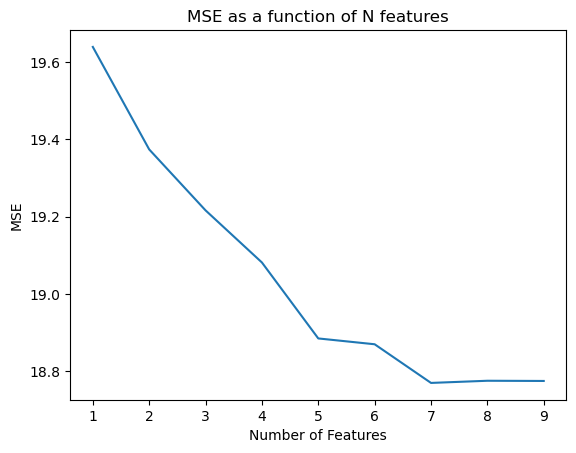

In [11]:
plt.plot(range(1,10), [MSE_function_p(i, X, y_aggregate) for i in range(1,10)])
plt.xlabel("Number of Features")
plt.ylabel("MSE")
plt.title("MSE as a function of N features")
plt.show()

i.e. this would suggest that we want the first 6 features, as more than that don't seem to really help reduce the MSE. What are these features?

In [16]:
mse_6_features = MSE_function_p(6, X, y_aggregate, True)
print(*mse_6_features, sep='\n')

[['TEAM_GOALS_5_last_match_sum'], 1.172249297387654]
[['TEAM_SAVES_5_last_match_sum'], -0.16119026229661348]
[['TEAM_GOALS_5_last_match_std'], -0.15180602301104618]
[['TEAM_SHOTS_ON_TARGET_5_last_match_sum'], 0.14475113497130482]
[['TEAM_REDCARDS_5_last_match_sum'], -0.10248449699636653]
[['TEAM_BALL_SAFE_5_last_match_sum'], 0.0813313283873309]


From what we see with Lasso regression, we are selecting similar features with both models.

## Predicting Form

Make the predictions for the training data set and save to file.

In [17]:
form_cols = [c[0][0] for c in mse_6_features]
print(*form_cols,sep='\n')

TEAM_GOALS_5_last_match_sum
TEAM_SAVES_5_last_match_sum
TEAM_GOALS_5_last_match_std
TEAM_SHOTS_ON_TARGET_5_last_match_sum
TEAM_REDCARDS_5_last_match_sum
TEAM_BALL_SAFE_5_last_match_sum


In [18]:
model = LinearRegression()
model.fit(X[form_cols], y_aggregate);
away_form, home_form = model.predict(X_away[form_cols]), model.predict(X_home[form_cols])
diff_form = [h-a for h,a in zip(home_form, away_form)]

In [19]:
form_data = pd.DataFrame({"AWAY_FORM_5_last_match_sum" : away_form, 
                          "HOME_FORM_5_last_match_sum" : home_form,
                          "DIFF_FORM_5_last_match_sum" : diff_form,})
# display(form_data.head())
scaler = MinMaxScaler(feature_range = (0,10))
form_data = pd.DataFrame(scaler.fit_transform(form_data), columns = form_data.columns)

In [22]:
form_data.to_csv("Form_Feature/training_form_feature.csv", index = False)

In [23]:
with open('Form_Feature/form_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [26]:
form_features = pd.DataFrame({'Feature' :form_cols})
form_features.to_csv('Form_Feature/form_features.csv', index = False)